In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pyspark.pandas as ps
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from waymo_open_dataset.protos import scenario_pb2 

spark = SparkSession.builder.appName("echipa team").getOrCreate()
sc = spark.sparkContext

2022-12-08 22:08:36.125237: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi1000/linux64/lib
2022-12-08 22:08:36.125266: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


22/12/08 22:08:39 WARN Utils: Your hostname, teofil-ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.100.4 instead (on interface wlp4s0)
22/12/08 22:08:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/08 22:08:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
DIRNAME = 'one'
scenarios = []
for filename in os.listdir(DIRNAME):
    filepath = os.path.join(DIRNAME, filename)
    dataset = tf.data.TFRecordDataset(filepath)
    for data in dataset:
        proto_string = data.numpy()
        proto = scenario_pb2.Scenario()
        proto.ParseFromString(proto_string)

        scenarios.append(proto)

2022-12-08 22:08:45.031006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 22:08:45.031247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi1000/linux64/lib
2022-12-08 22:08:45.031302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi1000/linux64/lib
2022-12-08 22:08:45.031348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory;

In [3]:
len(scenarios), sum([len(scenario.tracks) for scenario in scenarios])

(446, 30838)

In [48]:
# track = scenarios[0].tracks[0]
def state_to_array(track, column):
    return np.array(
        [getattr(state, column) for state in track.states],
        dtype='float'
    )
        
state_columns = [
    'center_x', 
    'center_y', 
    'center_z', 
    'heading', 
    'velocity_x', 
    'velocity_y', 
    'valid'
]
columns = ['scenario_id', 'track_id', 'object_type'] + state_columns
track_entries = []
for scenario in scenarios[:1]:
    for track in scenario.tracks:
        entry = [
            scenario.scenario_id, 
            track.id, 
            track.object_type
        ]
        for column in state_columns:
            arr = state_to_array(track, column)
            if column in ['center_x','center_y', 'center_z']:
                arr -= arr[0]
            entry.append(arr.tolist())
        
        track_entries.append(entry)
psdf = ps.DataFrame(track_entries, columns=columns)
sdf = psdf.to_spark() #index_col='index'

/home/teofil/anaconda3/lib/python3.9/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [49]:
len(scenarios), len(track_entries)

(446, 100)

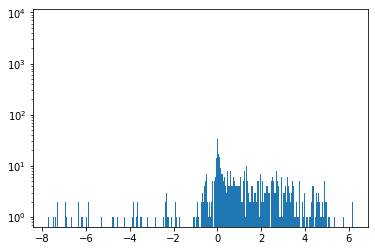

In [56]:

def plot_hist(sdf, column, buckets):
  hist = sdf.select(
    column
  ).rdd.flatMap(
    lambda x: x
  ).flatMap(lambda x: [i for i in x]).histogram(buckets)
  values, counts = hist
  # pairs = list(zip(counts, values))
  # pairs.sort(key=lambda p: p[1])
  # counts = [pair[0] for pair in pairs]
  # values = [pair[1] for pair in pairs]
  plt.bar(x=values[:-1], height=counts, width=np.diff(values), align='edge', log=True);
  # plt.xlim((-5,5));
  plt.show();
  # y_pos = np.arange(len(counts))
  # if x_strings:
  #   plt.xticks(y_pos, x_strings)
  # plt.bar(y_pos, counts, align='center')
  # plt.ylabel('Usage')
  # plt.title('Object type');
plot_hist(sdf, 'velocity_x', 1000);

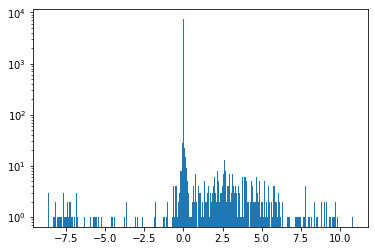

In [57]:

plot_hist(sdf, 'velocity_y', 1000);

ValueError: Column center_x has a non-numeric type (ArrayType(DoubleType(), True)), only numeric types are supported

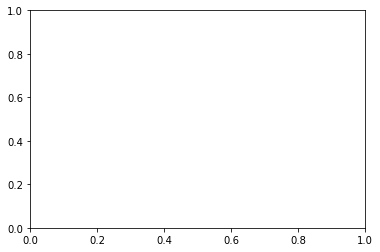

In [9]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist(ax, sdf.select('center_x'), bins = 3, color=['red'])

In [10]:
hist = sdf.select(
    $'center_x.*'
).rdd.flatMap(
    lambda x: x
).take(10)


AnalysisException: Can only star expand struct data types. Attribute: `ArrayBuffer(center_x)`

In [23]:
from pyspark.sql.functions import flatten
sdf.select(flatten(sdf.center_x).alias('r')).collect()
# sdf.select(sdf.center_x).take(1)

AnalysisException: cannot resolve 'flatten(center_x)' due to data type mismatch: The argument should be an array of arrays, but 'center_x' is of array<double> type.;
'Project [flatten(center_x#4) AS r#55]
+- Project [scenario_id#1, track_id#2L, object_type#3L, center_x#4, center_y#5, center_z#6, heading#7, velocity_x#8, velocity_y#9, valid#10]
   +- Project [__index_level_0__#0L, scenario_id#1, track_id#2L, object_type#3L, center_x#4, center_y#5, center_z#6, heading#7, velocity_x#8, velocity_y#9, valid#10, monotonically_increasing_id() AS __natural_order__#22L]
      +- LogicalRDD [__index_level_0__#0L, scenario_id#1, track_id#2L, object_type#3L, center_x#4, center_y#5, center_z#6, heading#7, velocity_x#8, velocity_y#9, valid#10], false


In [ ]:
plot_hist(sdf, 'valid', 2, x_strings=["VEHICLE", "PEDESTRIAN", "CYCLIST"])

In [ ]:
# TODO:
"""
 - hist(state, distante, valid)
    - heading
    - velocity 
    - 
 - track-uri suprapuse
 - speed_limit_mph
 - hist pe lane types https://github.com/waymo-research/waymo-open-dataset/blob/master/waymo_open_dataset/protos/map.proto#L146
 - stop sign 

 - free ahead
 - chaning lanes
 - TrafficSignalLaneState https://github.com/waymo-research/waymo-open-dataset/blob/master/waymo_open_dataset/protos/map.proto
 - conditionare pe train/validation
"""

# DONE
"""
 - object type distribution
"""